# Imports

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
import shap


# setting random state for reproducibility
SEED = 321
np.random.seed(SEED)

# set pandas to display more columns
pd.set_option('display.max_columns',50)

# Functions

In [2]:
# Model evaluation function
def evaluate_regression(model, X_train,y_train, X_test, y_test):
    """Evaluates a scikit learn regression model using r-squared and RMSE"""

    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train,
                                            squared=False)

    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")


    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test,
                                            squared=False)

    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

# Data Load

In [3]:
# Import model with joblib
loaded = joblib.load('random_forest_l01.joblib')

# This is needed because the RandomForest object doesn't exist outside of ran_for_pipe
ran_for_pipe = loaded['RandomForest']
linreg_pipe = loaded['LinearRegression']

loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression', 'RandomForest'])

In [4]:
# Load variables
X_train_df = loaded['X_train']
y_train = loaded['y_train']
X_test_df = loaded['X_test']
y_test = loaded['y_test']
preprocessor = loaded['preprocessor']
loaded_model = loaded['RandomForest']

# Easy access to rf model
rf_reg = ran_for_pipe.named_steps['randomforestregressor']

In [5]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

In [6]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

In [7]:
# Evaluate loaded model

# Use named_steps to get rf_reg model - function expects a model, not a pipeline.
# Giving the pipeline alone will cause an error.
evaluate_regression(ran_for_pipe['randomforestregressor'], X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.94	RMSE= 427.49
Test Data:	R^2= 0.56	RMSE= 1102.76


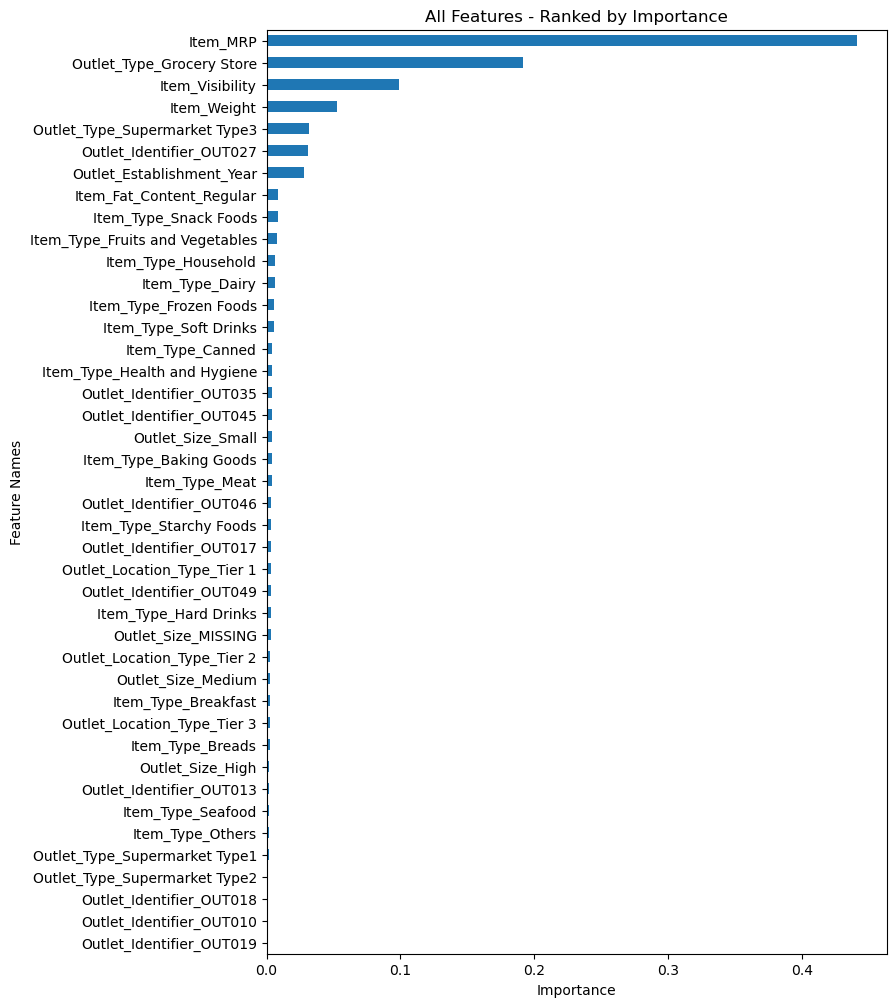

In [8]:
rf_importances = get_importances(loaded_model.named_steps['randomforestregressor'])
ax = plot_importance(rf_importances, figsize=(8,12))

# SHAP

In [9]:
# Initialize SHAP
shap.initjs()

In [10]:
# Check length of X_train_df
len(X_train_df)

6392

In [11]:
# Create X_shap variable
X_shap = shap.sample(X_train_df, nsamples = 400, random_state = SEED)
X_shap

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
3888       15.850         0.110653   36.9506                     2007.0   
2497       15.100         0.087407  221.8456                     1997.0   
7723       17.500         0.015592  184.8266                     2002.0   
8117       10.800         0.049820  243.2144                     2002.0   
7475       15.000         0.044999  140.4838                     2002.0   
...           ...              ...       ...                        ...   
292        12.850         0.033288  198.4768                     2002.0   
3035        8.895         0.088682  121.9730                     2009.0   
6832       10.395         0.030282  116.3176                     2009.0   
8455       18.000         0.073607  156.6972                     2007.0   
7795       19.600         0.047858   45.0770                     1987.0   

      Item_Fat_Content_Regular  Item_Type_Baking Goods  Item_Type_Breads  \
3888                       1.0                     0.0               0.0   
2497                       1.0                     0.0               0.0   
7723                       0.0                     0.0               0.0   
8117                       0.0                     0.0               0.0   
7475                       0.0                     0.0               0.0   
...                        ...                     ...               ...   
292                        0.0                     0.0               0.0   
3035                       1.0                     0.0               0.0   
6832                       0.0                     1.0               0.0   
8455                       0.0                     0.0               0.0   
7795                       0.0                     0.0               0.0   

      Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  \
3888                  0.0               0.0              0.0   
2497                  0.0               0.0              0.0   
7723                  0.0               0.0              0.0   
8117                  0.0               0.0              0.0   
7475                  0.0               0.0              0.0   
...                   ...               ...              ...   
292                   0.0               0.0              0.0   
3035                  0.0               0.0              0.0   
6832                  0.0               0.0              0.0   
8455                  0.0               1.0              0.0   
7795                  0.0               0.0              0.0   

      Item_Type_Frozen Foods  Item_Type_Fruits and Vegetables  \
3888                     1.0                              0.0   
2497                     0.0                              1.0   
7723                     0.0                              1.0   
8117                     0.0                              1.0   
7475                     0.0                              0.0   
...                      ...                              ...   
292                      0.0                              1.0   
3035                     0.0                              0.0   
6832                     0.0                              0.0   
8455                     0.0                              0.0   
7795                     0.0                              0.0   

      Item_Type_Hard Drinks  Item_Type_Health and Hygiene  \
3888                    0.0                           0.0   
2497                    0.0                           0.0   
7723                    0.0                           0.0   
8117                    0.0                           0.0   
7475                    0.0                           1.0   
...                     ...                           ...   
292                     0.0                           0.0   
3035                    0.0                           0.0   
6832                    0.0                           0.0   
8455                    0.0     

In [12]:
# Get corresponding y-values
y_shap = y_train.loc[X_shap.index]
y_shap

3888     759.0120
2497     663.1368
7723    2766.3990
8117    1225.0720
7475    1685.8056
          ...    
292     1379.5376
3035    2956.1520
6832    1259.6936
8455    4206.5244
7795     605.8780
Name: Item_Outlet_Sales, Length: 400, dtype: float64

In [13]:
# Instantiate explainer
explainer = shap.Explainer(loaded_model.named_steps['randomforestregressor'])
explainer


In [14]:
# %%time - Magic commands do not work properly with pylance and causes linting/highlighting issues
# Get shap values
shap_values = explainer(X_shap, y_shap)
shap_values.shape

(400, 42)

In [15]:
# Get shap values
shap_values = explainer(X_shap, y_shap)
shap_values.shape

(400, 42)

In [16]:
# Ensure that the "images" exists.
os.makedirs("images/", exist_ok=True)

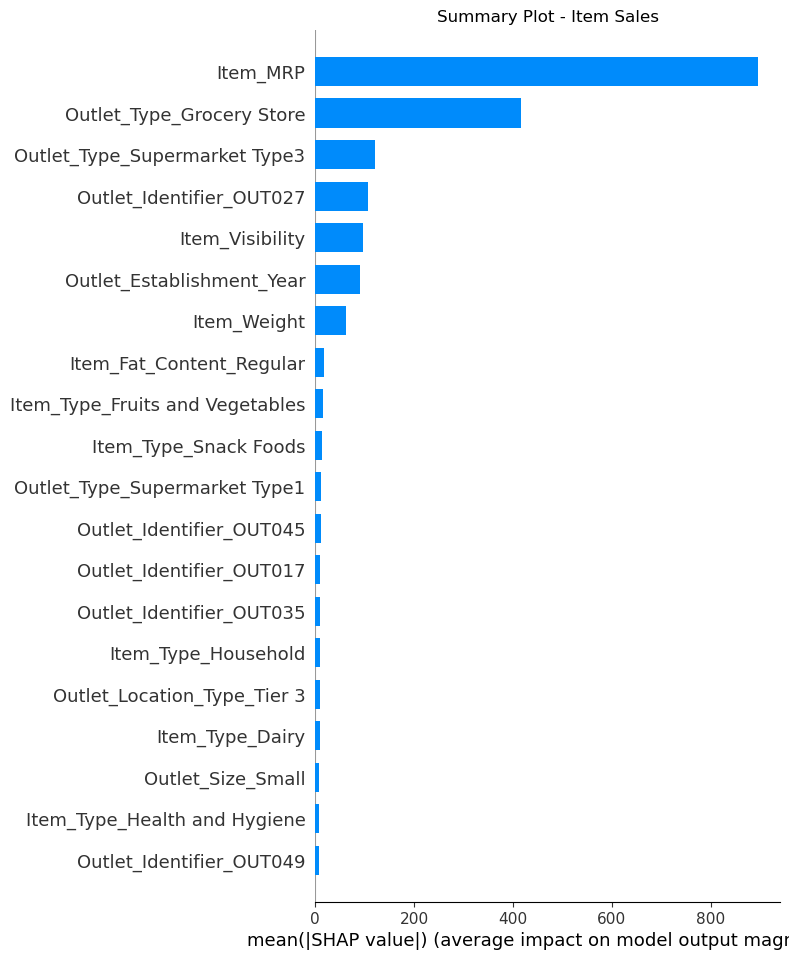

In [17]:
# Create shap bar plot & save bar plot
fig, ax = plt.subplots()
shap.summary_plot(shap_values, X_shap, plot_type = 'bar', show=False)
ax.set_title('Summary Plot - Item Sales');
fig.savefig('images/summary_plot_1.png')

![](images/top_10_important_features.png)

The SHAP plot and feature importances are both very similar.
- In both plots, Item_MRP is the top feature used
- Outlet_Type_GroceryStore is 2nd for both

The differences begin with the third row.
- The SHAP plot shows Item_Visibility at 5th but in the feature importance, it is ranked 3rd.
- Item_Weight is outside of the top 5 in the SHAP but is ranked 4th in the important features.

Overall, the top 5 majority of features are the same.

![]()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


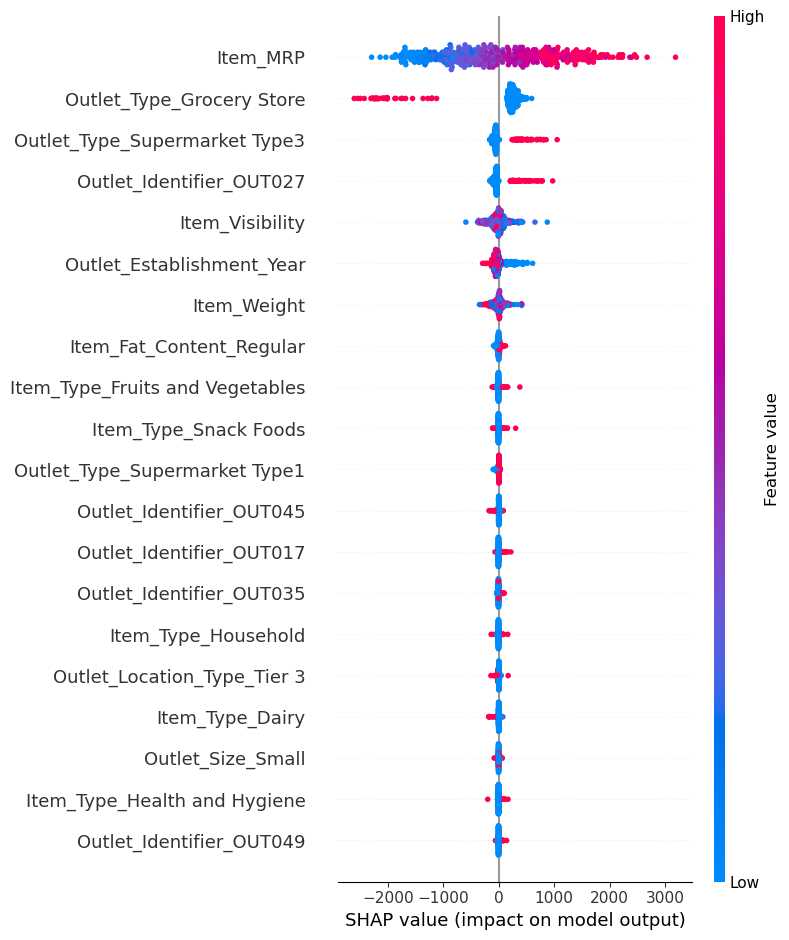

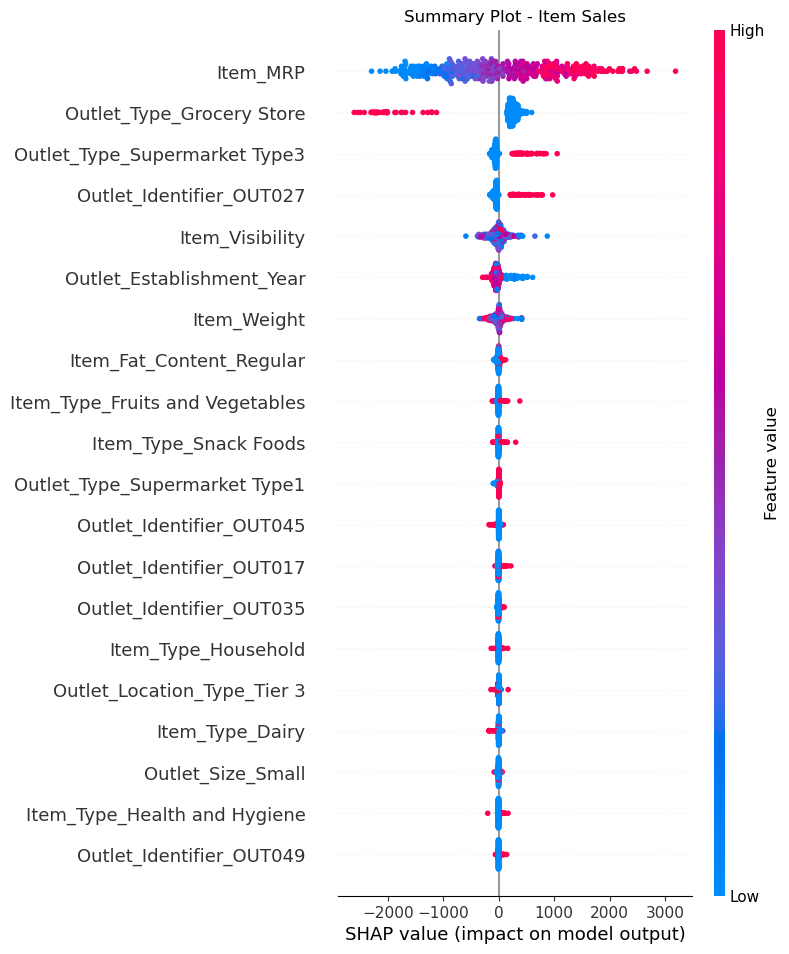

In [18]:
# Summary dot plot
shap.summary_plot(shap_values, features = X_shap)

# Save dot plot
fig, ax = plt.subplots()
shap.summary_plot(shap_values, X_shap, show=False)
ax.set_title('Summary Plot - Item Sales');
fig.savefig('images/summary_plot_2.png')

- Top three features:
    - Item_MRP
      - The plot shows a larger amount of high values on the right side of the plot. This means that higher values in this feature will increase sales.
    - Outlet_Type_Grocery
      - The majority of high values for this feature are on the left-hand side of the plot. Items sold from outlets identified as grocery stores will sell for a lesser amount.
    - Outlet_Type_Supermarket 3
      - There is a high concentraion of high values on the right-hand side of the plot. Items sold from outlets identified as supermarket 3 will see more sales.

### Save SHAP Plots

## Local Explanations

In [19]:
# Note - this type of plot is a global plot and not needed. It can be commented out.
# Come back and review it later.

# View global force plot
# force_plot = shap.force_plot(explainer.expected_value, shap_values.values, features=X_shap)

# # Without this, the plot would nearly unreadable with a dark theme
# from IPython.display import HTML
# HTML(f"<div style='background-color:Lavender;'>{shap.getjs() + force_plot.html()}</div>")


### Select Rows
- Refer to dot plot and pick a feature that has a major impact

In [20]:
X_shap = shap.sample(X_train_df, nsamples=400,random_state=321)
y_shap = y_train.loc[X_shap.index]


In [21]:
X_shap = X_shap.sort_index()
y_shap = y_shap.sort_index()
display(X_shap.head(),y_shap.head())

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
2          17.50         0.016760  141.6180                     1999.0   
15          9.00         0.069089   56.3614                     1997.0   
47         10.00         0.025880  265.2226                     2002.0   
150        14.60         0.151419   50.3692                     2007.0   
151        13.85         0.026002  161.5210                     2009.0   

     Item_Fat_Content_Regular  Item_Type_Baking Goods  Item_Type_Breads  \
2                         0.0                     0.0               0.0   
15                        1.0                     0.0               0.0   
47                        0.0                     0.0               0.0   
150                       0.0                     0.0               0.0   
151                       1.0                     0.0               0.0   

     Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  \
2                    0.0               0.0              0.0   
15                   1.0               0.0              0.0   
47                   0.0               1.0              0.0   
150                  0.0               0.0              0.0   
151                  0.0               0.0              0.0   

     Item_Type_Frozen Foods  Item_Type_Fruits and Vegetables  \
2                       0.0                              0.0   
15                      0.0                              0.0   
47                      0.0                              0.0   
150                     0.0                              0.0   
151                     1.0                              0.0   

     Item_Type_Hard Drinks  Item_Type_Health and Hygiene  Item_Type_Household  \
2                      0.0                           0.0                  0.0   
15                     0.0                           0.0                  0.0   
47                     0.0                           0.0                  0.0   
150                    0.0                           0.0                  0.0   
151                    0.0                           0.0                  0.0   

     Item_Type_Meat  Item_Type_Others  Item_Type_Seafood  \
2               1.0               0.0                0.0   
15              0.0               0.0                0.0   
47              0.0               0.0                0.0   
150             0.0               0.0                0.0   
151             0.0               0.0                0.0   

     Item_Type_Snack Foods  Item_Type_Soft Drinks  Item_Type_Starchy Foods  \
2                      0.0                    0.0                      0.0   
15                     0.0                    0.0                      0.0   
47                     0.0                    0.0                      0.0   
150                    0.0                    1.0                      0.0   
151                    0.0                    0.0                      0.0   

     Outlet_Identifier_OUT010  Outlet_Identifier_OUT013  \
2                         0.0                       0.0   
15                        0.0                       0.0   
47                        0.0                       0.0   
150                       0.0                       0.0   
151                       0.0                       0.0   

     Outlet_Identifier_OUT017  Outlet_Identifier_OUT018  \
2                         0.0                       0.0   
15                        0.0                       0.0   
47                        0.0                       0.0   
150                       1.0                       0.0   
151                       0.0                       1.0   

     Outlet_Identifier_OUT019  Outlet_Identifier_OUT027  \
2                         0.0                       0.0   
15                        0.0                       0.0   
47                        0.0                       0.0   
150                       0.0                       0.0   
151                    

2      2097.2700
15     1547.3192
47     5815.0972
150    1034.6532
151    1794.3310
Name: Item_Outlet_Sales, dtype: float64

In [22]:
explainer = shap.Explainer(rf_reg)
explainer

In [23]:
# Getting the shap values
shap_values = explainer(X_shap,y_shap)

In [24]:
X_shap_local = X_shap.reset_index(drop=True)
y_shap_local = y_shap.reset_index(drop=True)


<Axes: xlabel='Item_MRP', ylabel='Count'>

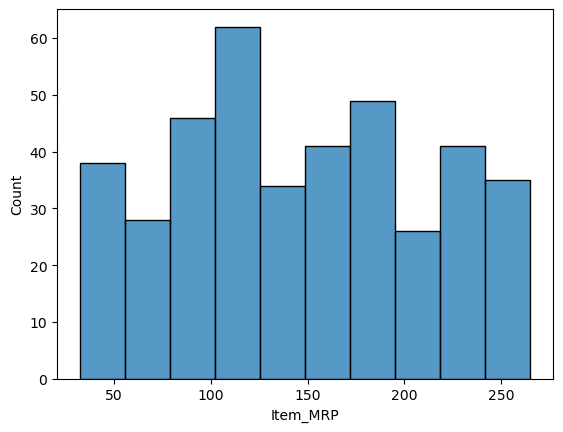

In [25]:
sns.histplot(X_shap_local['Item_MRP'])

In [26]:
# Get mean and median for Item_MRP
X_shap_local['Item_MRP'].agg(['mean','median'])

mean      146.899304
median    144.028600
Name: Item_MRP, dtype: float64

#### Filter Features

In [27]:
# Filter for high mrp
# high_price = X_shap_local['Item_MRP'] > 100.00

# Filter for grocery stores
grocery = X_shap_local['Outlet_Type_Grocery Store'] == 1
groc_only = X_shap_local[grocery]


# Filter for Supermarket Type3
supermarket = X_shap_local['Outlet_Type_Supermarket Type3'] == 1
supermarket_only = X_shap_local[supermarket]


# display(high_price.value_counts())
display(grocery.value_counts())
display(supermarket.value_counts())

False    365
True      35
Name: Outlet_Type_Grocery Store, dtype: int64

False    350
True      50
Name: Outlet_Type_Supermarket Type3, dtype: int64

In [28]:
# This replaces row_1_select and ex_row_1 is no longer needed
# this will allow for an explanation on why we chose a specific value
#! Update the old references to row_1_select

# Get the highest MRP from grocery store
highest_mrp_grocery = groc_only['Item_MRP'].idxmax()
highest_mrp_grocery

244

#### Example 1

In [29]:
# View row
print(f"- Row #: {highest_mrp_grocery}")
print(f"- Target: {y_shap.iloc[highest_mrp_grocery]}")
X_shap.iloc[highest_mrp_grocery].round(2)

- Row #: 244
- Target: 1281.665


Item_Weight                          15.20
Item_Visibility                       0.00
Item_MRP                            256.03
Outlet_Establishment_Year          1998.00
Item_Fat_Content_Regular              0.00
Item_Type_Baking Goods                0.00
Item_Type_Breads                      0.00
Item_Type_Breakfast                   0.00
Item_Type_Canned                      0.00
Item_Type_Dairy                       0.00
Item_Type_Frozen Foods                0.00
Item_Type_Fruits and Vegetables       0.00
Item_Type_Hard Drinks                 0.00
Item_Type_Health and Hygiene          0.00
Item_Type_Household                   0.00
Item_Type_Meat                        1.00
Item_Type_Others                      0.00
Item_Type_Seafood                     0.00
Item_Type_Snack Foods                 0.00
Item_Type_Soft Drinks                 0.00
Item_Type_Starchy Foods               0.00
Outlet_Identifier_OUT010              1.00
Outlet_Identifier_OUT013              0.00
Outlet_Iden

In [30]:
# Individual forceplot
force_plot = shap.force_plot(explainer.expected_value,
                shap_values= X_shap_local.iloc[highest_mrp_grocery].values,
               features=X_shap_local.iloc[highest_mrp_grocery])

from IPython.display import HTML
HTML(f"<div style='background-color:Lavender;'>{shap.getjs() + force_plot.html()}</div>")


In [36]:
from lime.lime_tabular import LimeTabularExplainer
#Set instance of explainer
lime_explainer =LimeTabularExplainer(training_data=X_shap.values, feature_names=X_shap.columns, mode='regression')
lime_explainer

In [37]:
#LIME plot
exp = lime_explainer.explain_instance(X_shap.iloc[highest_mrp_grocery],
                               rf_reg.predict)
exp.show_in_notebook()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


In [38]:
## getting the explanation values as a list for people using a dark theme
exp_df = pd.DataFrame(exp.as_list(),columns=['Effect','Value'])
exp_df

Effect        Value
0       Outlet_Type_Grocery Store > 0.00 -2222.064004
1                      Item_MRP > 195.71  1835.975361
2  Outlet_Type_Supermarket Type3 <= 0.00  -512.732997
3       Outlet_Identifier_OUT027 <= 0.00  -472.734050
4          Item_Type_Hard Drinks <= 0.00  -169.603764
5            Item_Type_Household <= 0.00  -151.794960
6        Outlet_Identifier_OUT010 > 0.00  -115.422682
7                Item_Visibility <= 0.03    98.971757
8               Item_Type_Others <= 0.00   -83.724559
9       Outlet_Identifier_OUT049 <= 0.00   -82.203091

##### Interpretations

**Lime Plot:**
- The fact that the store is not a grocery store increased the model predicted item sales by 2209.
- The positive value of 2209 suggestes that the identification of Outlet_Type Grocery Store is **associated with higher sales.**


Update the lower ones.
- Items with an MRP less than or equal to 98.82 may sell nearly 1800 units less.
- Items with an MRP of 144.03 are predicted to reduce sales by 598 units.
- Stores identified as Supermarket Type3 are predicted to have lower sales by 579 units.

In [ ]:
## getting the explanation values as a list for people using a dark theme
exp_plot = exp.as_pyplot_figure()

#### Example 2

In [31]:
supermarket_only.idxmax()

Item_Weight                         17
Item_Visibility                    111
Item_MRP                           231
Outlet_Establishment_Year           17
Item_Fat_Content_Regular            17
Item_Type_Baking Goods             104
Item_Type_Breads                   205
Item_Type_Breakfast                357
Item_Type_Canned                    86
Item_Type_Dairy                    282
Item_Type_Frozen Foods             251
Item_Type_Fruits and Vegetables     17
Item_Type_Hard Drinks              212
Item_Type_Health and Hygiene        32
Item_Type_Household                138
Item_Type_Meat                     241
Item_Type_Others                    22
Item_Type_Seafood                   17
Item_Type_Snack Foods               23
Item_Type_Soft Drinks              223
Item_Type_Starchy Foods             47
Outlet_Identifier_OUT010            17
Outlet_Identifier_OUT013            17
Outlet_Identifier_OUT017            17
Outlet_Identifier_OUT018            17
Outlet_Identifier_OUT019 

In [32]:
highest_mrp_supermarket = supermarket_only['Item_MRP'].idxmax()
highest_mrp_supermarket

231

In [33]:
# View row
print(f"- Row #: {highest_mrp_supermarket}")
print(f"- Target: {y_shap.iloc[highest_mrp_supermarket]}")
X_shap.iloc[highest_mrp_supermarket].round(2)

- Row #: 231
- Target: 7646.0472


Item_Weight                          12.90
Item_Visibility                       0.08
Item_MRP                            262.76
Outlet_Establishment_Year          1985.00
Item_Fat_Content_Regular              1.00
Item_Type_Baking Goods                1.00
Item_Type_Breads                      0.00
Item_Type_Breakfast                   0.00
Item_Type_Canned                      0.00
Item_Type_Dairy                       0.00
Item_Type_Frozen Foods                0.00
Item_Type_Fruits and Vegetables       0.00
Item_Type_Hard Drinks                 0.00
Item_Type_Health and Hygiene          0.00
Item_Type_Household                   0.00
Item_Type_Meat                        0.00
Item_Type_Others                      0.00
Item_Type_Seafood                     0.00
Item_Type_Snack Foods                 0.00
Item_Type_Soft Drinks                 0.00
Item_Type_Starchy Foods               0.00
Outlet_Identifier_OUT010              0.00
Outlet_Identifier_OUT013              0.00
Outlet_Iden

In [34]:
# Individual forceplot
force_plot = shap.force_plot(explainer.expected_value,
                shap_values= X_shap_local.iloc[highest_mrp_supermarket].values,
               features=X_shap_local.iloc[highest_mrp_supermarket])

from IPython.display import HTML
HTML(f"<div style='background-color:Lavender;'>{shap.getjs() + force_plot.html()}</div>")


##### Lime Plot

In [41]:
#Set instance of explainer
lime_explainer =LimeTabularExplainer(training_data=X_shap.values, feature_names=X_shap.columns, mode='regression')
lime_explainer

In [42]:
#LIME plot
exp = lime_explainer.explain_instance(X_shap.iloc[highest_mrp_supermarket],
                               rf_reg.predict)
exp.show_in_notebook()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


In [43]:
## getting the explanation values as a list for people using a dark theme
exp_df2 = pd.DataFrame(exp.as_list(),columns=['Effect','Value'])
exp_df2

Effect        Value
0     Outlet_Type_Grocery Store <= 0.00  2259.350033
1                     Item_MRP > 195.71  1869.407283
2  Outlet_Type_Supermarket Type3 > 0.00   651.206816
3       Outlet_Identifier_OUT027 > 0.00   548.653979
4       Item_Type_Starchy Foods <= 0.00  -193.912222
5           Item_Type_Breakfast <= 0.00  -191.132006
6             Item_Type_Seafood <= 0.00  -185.491689
7  Outlet_Establishment_Year <= 1987.00   168.854909
8      Outlet_Identifier_OUT010 <= 0.00   156.537077
9         Item_Type_Hard Drinks <= 0.00  -111.805326

##### Interpretations

### Final Conclusion